<a href="https://colab.research.google.com/github/Rhqo/Toy-Models-of-Superposition/blob/main/KBH_Toy_Models_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My_Toy_Models
Class 정의, 모델 정의, 함수 정의 등 논문에 있는 코드 활용

In [61]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Optional
import numpy as np
from tqdm import trange
import time
import einops
import matplotlib.pyplot as plt
import math

In [62]:
# 디바이스 체크
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class Config:
    def __init__(self, n_features: int, n_hidden: int, n_instances: int):
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_instances = n_instances

class Model(nn.Module):
    def __init__(self,
                config,
                activation=True,
                feature_probability: Optional[torch.Tensor] = None,
                importance: Optional[torch.Tensor] = None,
                device='cuda'):
        super().__init__()
        self.config = config
        self.activation = activation
        self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b_final
        if self.activation:
            out = F.relu(out)
        return out

    def hidden(self, features):
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        return hidden

    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
            feat,
            torch.zeros((), device=self.W.device),
        )
        return batch

def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()

      if hooks:
        hook_data = dict(model=model,
                         step=step,
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )

# 3D to 2D Projection ($h = Wx$)
$x$는 3차원 -> n_features = 3 \
$h$는 2차원 -> n_hidden = 2


### ※ Feature $X$가 Sparse하다?
$S_i := x_i\text{가 0일 확률}$\
$S_i = S$

Text(0.5, 0, 'x3')

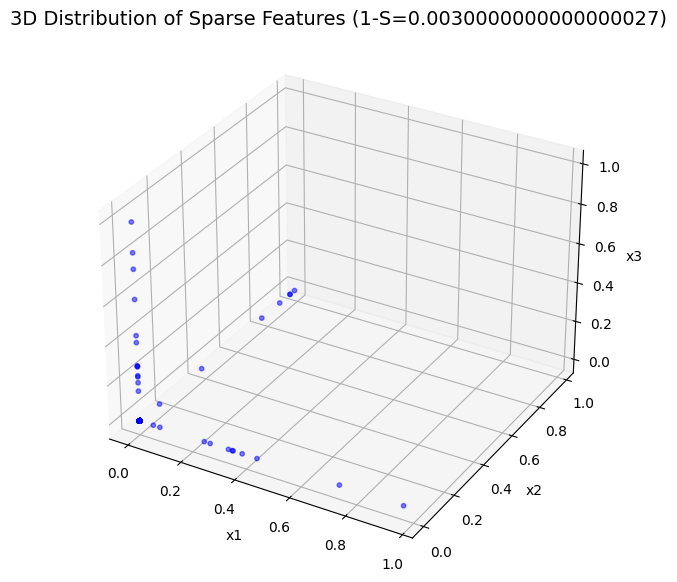

In [63]:
# 설정
config = Config(
    n_features=3,  # 특징 수
    n_hidden=2,    # 은닉 차원 수 (2D로 투영)
    n_instances=1000,  # 데이터 인스턴스 수
)

####################################################################
# 특징이 희소하다는 것의 의미 -> sparsity를 바꿔가며 데이터 분포 확인 가능합니다 #
####################################################################

# 희소성 파라미터 S (xi가 0일 확률, [0, 1))
sparsity = 0.997

# generate_batch 함수 사용하기 위해 모델 정의
model = Model(
    config=config,
    device=DEVICE,
    importance=(0.7 ** torch.arange(config.n_features))[None, :],
    feature_probability=torch.full((config.n_instances, 1), 1-sparsity)
)

# Plotting the 3D distribution of x
x = model.generate_batch(config.n_instances)

x_distribute = x.cpu().numpy()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_distribute[:, 0], x_distribute[:, 1], x_distribute[:, 2], alpha=0.5, s=10, c='b')

# Setting labels
ax.set_title(f'3D Distribution of Sparse Features (1-S={1-sparsity})', fontsize=14)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

## ReLU Model ($S$ = train sparsity)

In [64]:
# 설정
config = Config(
    n_features=3,  # 특징 수
    n_hidden=2,    # 은닉 차원 수 (2D로 투영)
    n_instances=1,  # 데이터 인스턴스 수
)

# 희소성 파라미터 S (xi가 0일 확률, [0, 1))
train_sparsity = 0.999

In [65]:
# 모델 정의
relu_model = Model(
    config=config,
    activation=True,  # ReLU 활성화 적용
    device=DEVICE,
    importance=(0.7 ** torch.arange(config.n_features))[None, :],
    feature_probability=torch.full((config.n_instances, 1), 1-train_sparsity)
)

In [66]:
# 모델 학습
optimize(relu_model)

100%|██████████| 10000/10000 [00:05<00:00, 1956.88it/s, loss=2.56e-12, lr=0.001]


### $S = \text{test sparsity}$
인 test data로 inference

In [67]:
# 특정 sparsity 데이터 생성
test_sparsity = 0.9
n_batch = 1000
x = torch.rand((n_batch, config.n_instances, config.n_features), device=DEVICE)
mask = torch.rand((n_batch, config.n_instances, config.n_features), device=x.device) <= 1-test_sparsity
values = torch.rand((n_batch, config.n_instances, config.n_features), device=x.device)
x = torch.where(mask, values, torch.zeros_like(x))

In [83]:
# 포워드 패스 및 투영
with torch.no_grad():
    x_tensor = torch.tensor(x, dtype=torch.float32, device=DEVICE)
    relu_hidden = relu_model.hidden(x_tensor).cpu().numpy()
    relu_W = relu_model.W.detach().cpu().numpy()

x = x.reshape(-1, 3)
relu_hidden = relu_hidden.reshape(-1, 2)

<ipython-input-83-ec567426eee4>:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



### 시각화
$x_1 = R$, $x_2 = G$, $x_3 = B$ \
3차원 데이터가 2차원에 어떻게 임베딩되었는지 직관적으로 알기 위해 RGB를 사용

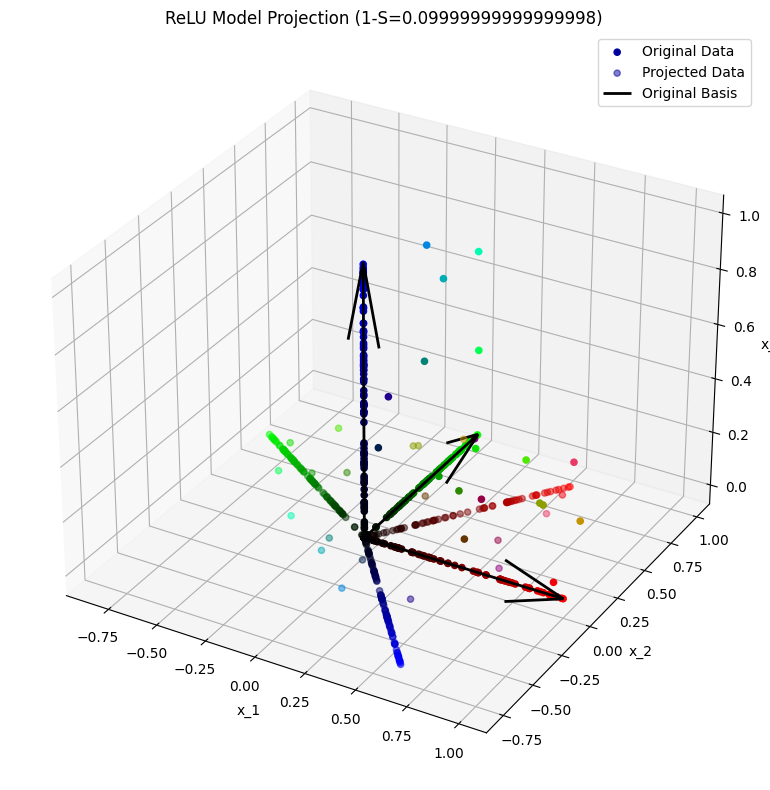

In [69]:
x_min = x.min(dim=0, keepdim=True).values  # (1, 3)
x_max = x.max(dim=0, keepdim=True).values  # (1, 3)
x_normalized = (x - x_min) / (x_max - x_min + 1e-8)

colors = x_normalized.cpu().numpy()

# 시각화
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터 및 은닉 투영 데이터 시각화
ax.scatter(x[:, 0].cpu(), x[:, 1].cpu(), x[:, 2].cpu(), c=colors, alpha=1,label='Original Data')
ax.scatter(relu_hidden[:, 0], relu_hidden[:, 1], np.zeros_like(relu_hidden[:, 0]), c=colors, alpha=0.5, label='Projected Data')

# 기존의 3차원 기저 벡터 시각화
ax.quiver(
    0, 0, 0,
    [1, 0, 0], [0, 1, 0], [0, 0, 1],
    color='black', linewidth=2, label='Original Basis'
)

# 라벨 및 제목
ax.set_title(f'ReLU Model Projection (1-S={1-test_sparsity})')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('x_3')
ax.legend()

plt.tight_layout()
plt.show()

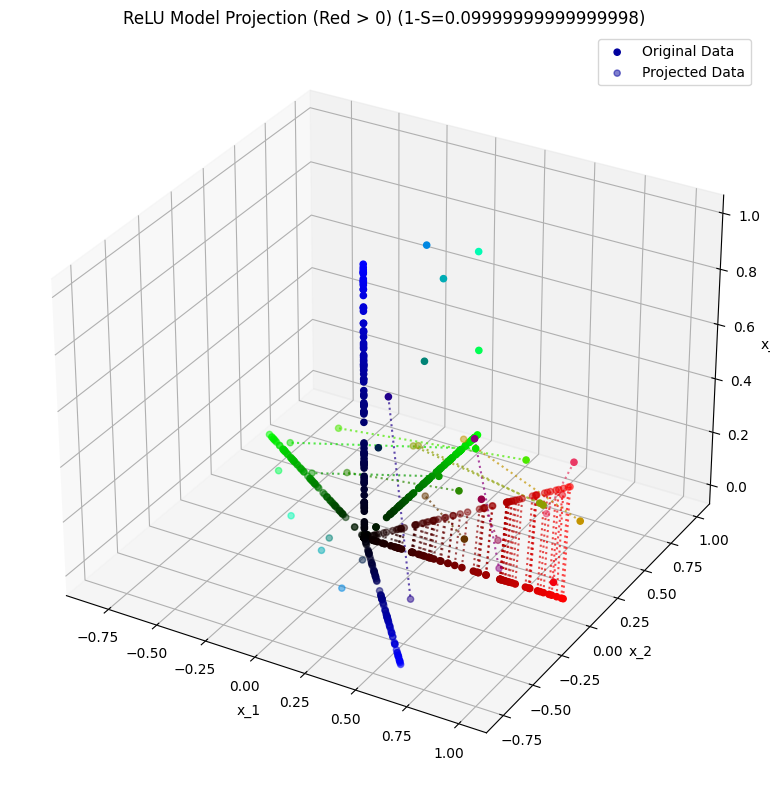

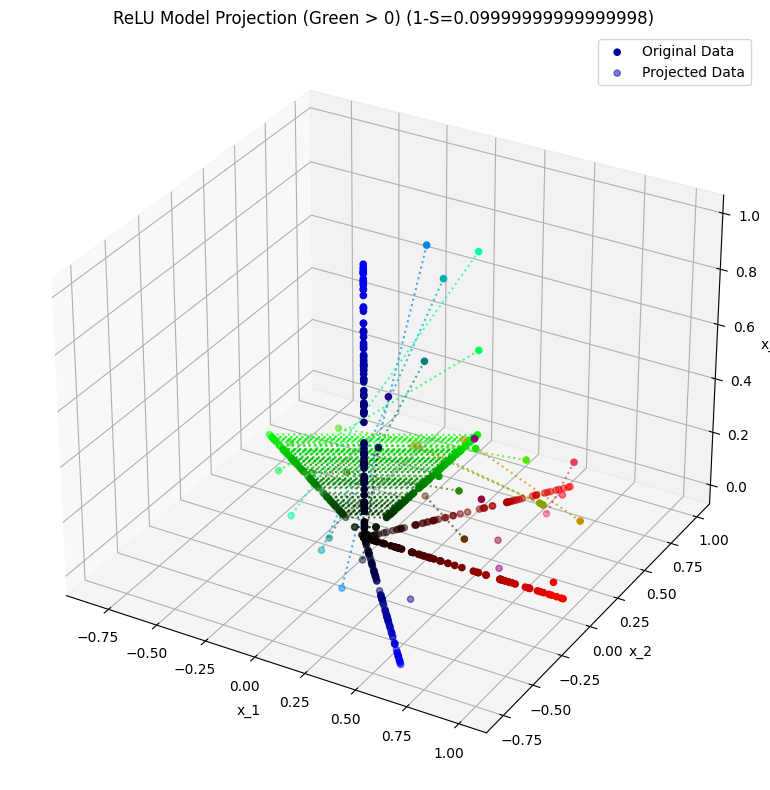

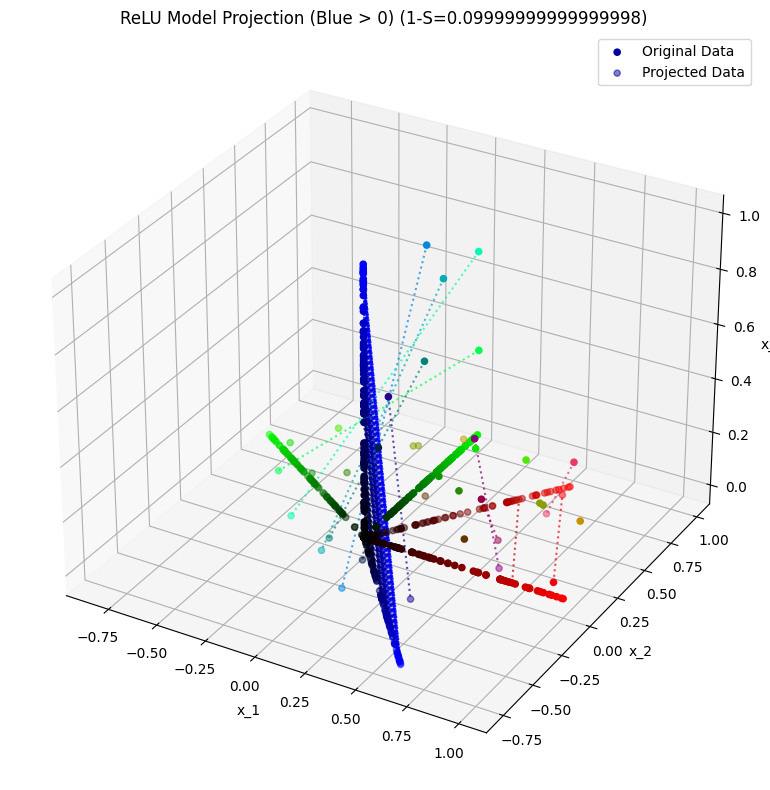

In [70]:
# R, G, B 채널에 대한 시각화
channel_names = ['Red', 'Green', 'Blue']

for i in range(3):  # 0 for R, 1 for G, 2 for B
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 원본 데이터 및 은닉 투영 데이터 시각화
    ax.scatter(x[:, 0].cpu(), x[:, 1].cpu(), x[:, 2].cpu(), c=colors, alpha=1, label='Original Data')
    ax.scatter(relu_hidden[:, 0], relu_hidden[:, 1], np.zeros_like(relu_hidden[:, 0]), c=colors, alpha=0.5, label='Projected Data')

    # 데이터 연결선 그리기 (i번째 채널이 0을 초과하는 경우에만 그리기)
    for j in range(len(x)):
        if colors[j, i] > 0:  # R, G, B 중 i번째 채널이 0보다 큰 경우
            ax.plot([x[j, 0].cpu(), relu_hidden[j, 0]],
                    [x[j, 1].cpu(), relu_hidden[j, 1]],
                    [x[j, 2].cpu(), 0],
                    c=colors[j],
                    alpha=0.7,
                    linestyle='dotted')

    # 라벨 및 제목 설정
    ax.set_title(f'ReLU Model Projection ({channel_names[i]} > 0) (1-S={1 - test_sparsity})')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('x_3')
    ax.legend()

    plt.tight_layout()
    plt.show()


In [71]:
import numpy as np
import plotly.graph_objects as go

# R, G, B 채널 이름
channel_names = ['Red', 'Green', 'Blue']

# 하나의 3D 그래프에 모든 채널 시각화
fig = go.Figure()

# R, G, B 채널에 대한 시각화
for i in range(3):  # 0 for R, 1 for G, 2 for B
    # 원본 데이터 시각화
    original_data = go.Scatter3d(
        x=x[:, 0].cpu().numpy() if hasattr(x[:, 0], 'cpu') else x[:, 0],
        y=x[:, 1].cpu().numpy() if hasattr(x[:, 1], 'cpu') else x[:, 1],
        z=x[:, 2].cpu().numpy() if hasattr(x[:, 2], 'cpu') else x[:, 2],
        mode='markers',
        marker=dict(size=5, color=colors, opacity=1),
        name=f'Original Data ({channel_names[i]})',
        legendgroup=f'channel_{i}'
    )

    # 투영된 데이터 시각화
    projected_data = go.Scatter3d(
        x=relu_hidden[:, 0].numpy() if hasattr(relu_hidden[:, 0], 'numpy') else relu_hidden[:, 0],
        y=relu_hidden[:, 1].numpy() if hasattr(relu_hidden[:, 1], 'numpy') else relu_hidden[:, 1],
        z=np.zeros_like(relu_hidden[:, 0]),
        mode='markers',
        marker=dict(size=5, color=colors, opacity=0.5),
        name=f'Projected Data ({channel_names[i]})',
        legendgroup=f'channel_{i}'
    )

    # 연결선 추가
    for j in range(len(x)):
        if colors[j, i] > 0:  # R, G, B 중 i번째 채널이 0보다 큰 경우에만 연결선 추가
            line = go.Scatter3d(
                x=[x[j, 0].cpu().numpy() if hasattr(x[j, 0], 'cpu') else x[j, 0], relu_hidden[j, 0].numpy() if hasattr(relu_hidden[j, 0], 'numpy') else relu_hidden[j, 0]],
                y=[x[j, 1].cpu().numpy() if hasattr(x[j, 1], 'cpu') else x[j, 1], relu_hidden[j, 1].numpy() if hasattr(relu_hidden[j, 1], 'numpy') else relu_hidden[j, 1]],
                z=[x[j, 2].cpu().numpy() if hasattr(x[j, 2], 'cpu') else x[j, 2], 0],
                mode='lines',
                line=dict(color=f'rgb({int(colors[j, 0] * 255)}, {int(colors[j, 1] * 255)}, {int(colors[j, 2] * 255)})', width=4, dash='dot'),
                showlegend=False  # 연결선에 대한 범례는 숨김
            )
            fig.add_trace(line)

    fig.add_trace(original_data)
    fig.add_trace(projected_data)

# 축 및 레이아웃 설정
fig.update_layout(
    title_text=f'ReLU Model Projection for R, G, B Channels (1-S={1 - test_sparsity})',
    scene=dict(
        xaxis_title='x_1',
        yaxis_title='x_2',
        zaxis_title='x_3'
    ),
    height=800,
    width=1200,
    showlegend=True
)

# 인터랙티브 플롯 표시
fig.show()

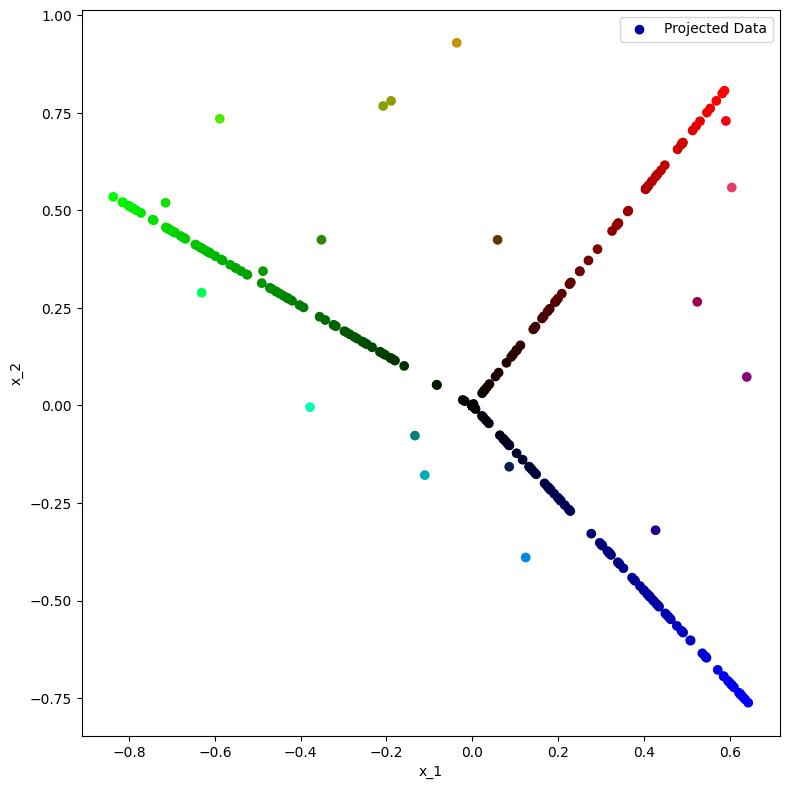

In [72]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(relu_hidden[:, 0], relu_hidden[:, 1], c=colors, alpha=1, label='Projected Data')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend()

plt.tight_layout()
plt.show()

In [117]:
# Extract two 3D vectors from relu_W
vector1 = relu_W[:, :, 0].flatten()
vector2 = relu_W[:, :, 1].flatten()
print(vector1, vector2)

# Create a meshgrid to visualize the plane spanned by the two vectors
u = np.linspace(-1, 1, 10)
v = np.linspace(-1, 1, 10)
U, V = np.meshgrid(u, v)

# Plane points are a linear combination of the two vectors
X = U * vector1[0] + V * vector2[0]
Y = U * vector1[1] + V * vector2[1]
Z = U * vector1[2] + V * vector2[2]

# Scatter plot for original and projected data
scatter_original = go.Scatter3d(
    x=x[:, 0].cpu().numpy(),
    y=x[:, 1].cpu().numpy(),
    z=x[:, 2].cpu().numpy(),
    mode='markers',
    marker=dict(size=5, color=colors, opacity=1),
    name='Original Data'
)

# Project scatter points onto the plane
A = np.column_stack([vector1, vector2])
projected_coords = np.linalg.lstsq(A, x.cpu().numpy().T, rcond=None)[0]  # Calculate the coefficients for the plane projection
projected_points = A @ projected_coords  # Project the points onto the plane
scatter_projected = go.Scatter3d(
    x=projected_points[0, :],
    y=projected_points[1, :],
    z=projected_points[2, :],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.5),
    name='Projected Data'
)

# Create a surface plot for the plane
plane_surface = go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale=[[0, 'gray'], [1, 'gray']],
    opacity=0.5,
    showscale=False,
    name='Span Plane'
)

# Combine all elements for the plot
fig = go.Figure(data=[scatter_original, scatter_projected, plane_surface])

# Set layout options
fig.update_layout(
    title=f'ReLU Model Projection (1-S={1-test_sparsity})',
    scene=dict(
        xaxis_title='x_1',
        yaxis_title='x_2',
        zaxis_title='x_3'
    )
)

# Show the plot
fig.show()


[ 0.5887936  -0.84254915  0.6486656 ] [ 0.8082259   0.53854483 -0.76825833]


## Linear Model ($S$ = train sparsity)

In [108]:
# 희소성 파라미터 S (xi가 0일 확률, [0, 1))
train_sparsity = 0.997

In [109]:
# 모델 정의
linear_model = Model(
    config=config,
    activation=False,  # activation 함수 미적용
    device=DEVICE,
    importance=(0.7 ** torch.arange(config.n_features))[None, :],
    feature_probability=torch.full((config.n_instances, 1), 1-train_sparsity)
)

In [110]:
# 모델 학습
optimize(linear_model)

100%|██████████| 10000/10000 [00:04<00:00, 2027.26it/s, loss=6.03e-5, lr=0.001]


### $S = \text{test sparsity}$
인 test data로 inference

In [118]:
# 포워드 패스 및 투영
# 기존 x는 있으므로, x_hidden만 추론 진행
with torch.no_grad():
    linear_hidden = linear_model.hidden(x_tensor).cpu().numpy()
    linear_W = linear_model.W.detach().cpu().numpy()

linear_hidden = linear_hidden.reshape(-1, 2)

### 시각화
$x_1 = R$, $x_2 = G$, $x_3 = B$ \
3차원 데이터가 2차원에 어떻게 임베딩되었는지 직관적으로 알기 위해 RGB를 사용

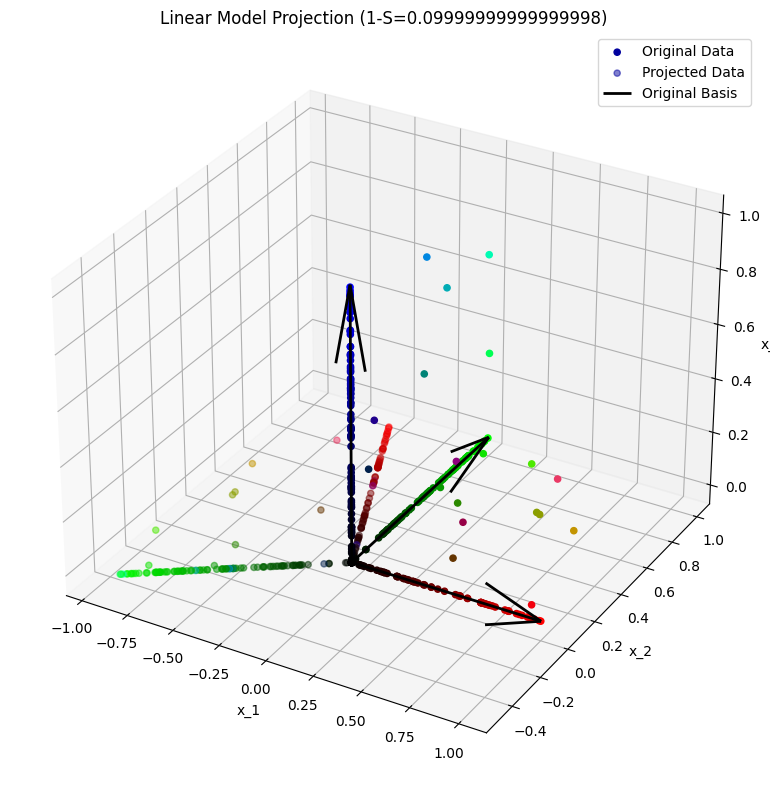

In [119]:
x_min = x.min(dim=0, keepdim=True).values  # (1, 3)
x_max = x.max(dim=0, keepdim=True).values  # (1, 3)
x_normalized = (x - x_min) / (x_max - x_min + 1e-8)

# Map normalized components to colors
colors = x_normalized.cpu().numpy()

# 시각화
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터 및 은닉 투영 데이터 시각화
ax.scatter(x[:, 0].cpu(), x[:, 1].cpu(), x[:, 2].cpu(), c=colors, alpha=1,label='Original Data')
ax.scatter(linear_hidden[:, 0], linear_hidden[:, 1], np.zeros_like(linear_hidden[:, 0]), c=colors, alpha=0.5, label='Projected Data')

# 기존의 3차원 기저 벡터 시각화
ax.quiver(
    0, 0, 0,
    [1, 0, 0], [0, 1, 0], [0, 0, 1],
    color='black', linewidth=2, label='Original Basis'
)

# 라벨 및 제목
ax.set_title(f'Linear Model Projection (1-S={1-test_sparsity})')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('x_3')
ax.legend()

plt.tight_layout()
plt.show()

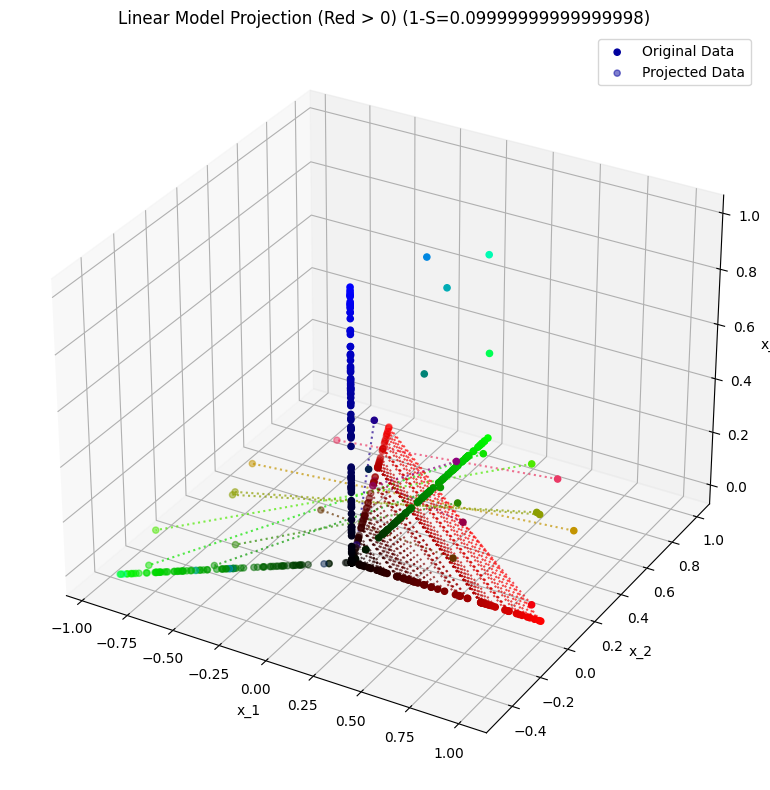

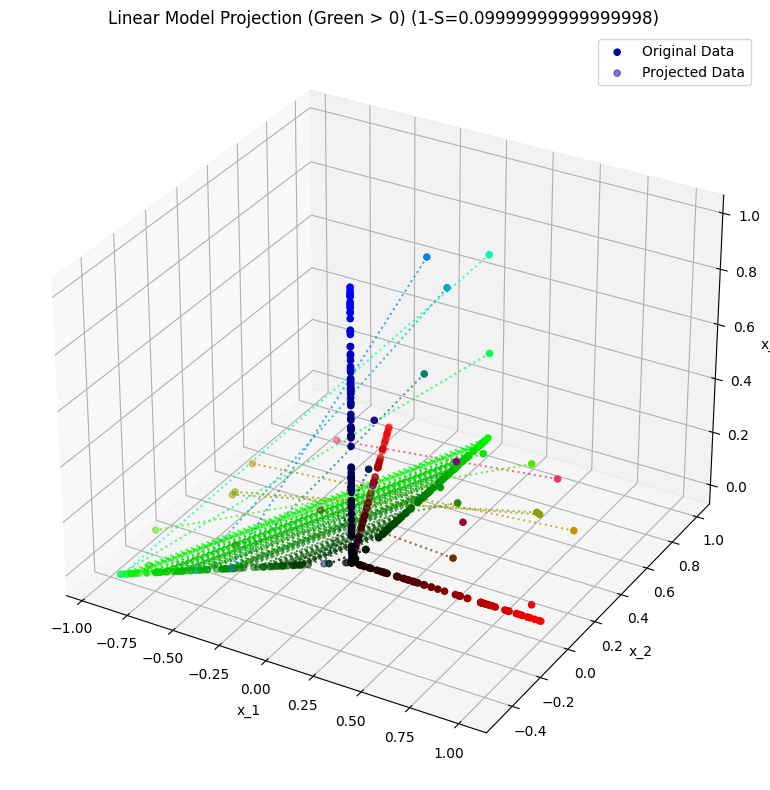

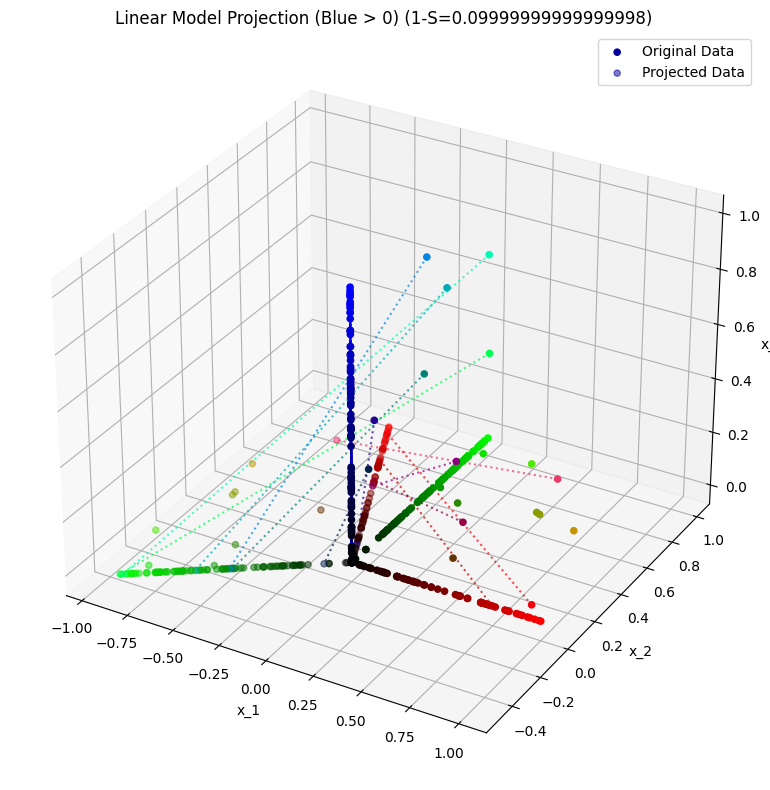

In [120]:
# R, G, B 채널에 대한 시각화
channel_names = ['Red', 'Green', 'Blue']

for i in range(3):  # 0 for R, 1 for G, 2 for B
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 원본 데이터 및 은닉 투영 데이터 시각화
    ax.scatter(x[:, 0].cpu(), x[:, 1].cpu(), x[:, 2].cpu(), c=colors, alpha=1, label='Original Data')
    ax.scatter(linear_hidden[:, 0], linear_hidden[:, 1], np.zeros_like(linear_hidden[:, 0]), c=colors, alpha=0.5, label='Projected Data')

    # 데이터 연결선 그리기 (i번째 채널이 0을 초과하는 경우에만 그리기)
    for j in range(len(x)):
        if colors[j, i] > 0:  # R, G, B 중 i번째 채널이 0보다 큰 경우
            ax.plot([x[j, 0].cpu(), linear_hidden[j, 0]],
                    [x[j, 1].cpu(), linear_hidden[j, 1]],
                    [x[j, 2].cpu(), 0],
                    c=colors[j],
                    alpha=0.7,
                    linestyle='dotted')

    # 라벨 및 제목 설정
    ax.set_title(f'Linear Model Projection ({channel_names[i]} > 0) (1-S={1 - test_sparsity})')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('x_3')
    ax.legend()

    plt.tight_layout()
    plt.show()


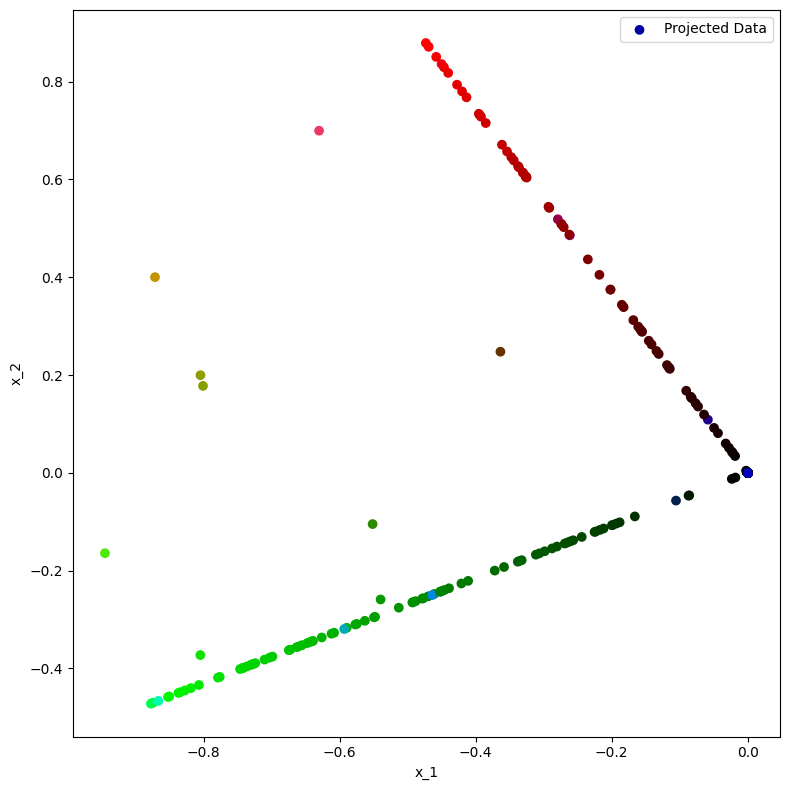

In [121]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(linear_hidden[:, 0], linear_hidden[:, 1], c=colors, alpha=1, label='Projected Data')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend()

plt.tight_layout()
plt.show()

In [122]:
# Extract two 3D vectors from linear_W
vector1 = linear_W[:, :, 0].flatten()
vector2 = linear_W[:, :, 1].flatten()
print(vector1, vector2)

# Create a meshgrid to visualize the plane spanned by the two vectors
u = np.linspace(-1, 1, 10)
v = np.linspace(-1, 1, 10)
U, V = np.meshgrid(u, v)

# Plane points are a linear combination of the two vectors
X = U * vector1[0] + V * vector2[0]
Y = U * vector1[1] + V * vector2[1]
Z = U * vector1[2] + V * vector2[2]

# Scatter plot for original and projected data
scatter_original = go.Scatter3d(
    x=x[:, 0].cpu().numpy(),
    y=x[:, 1].cpu().numpy(),
    z=x[:, 2].cpu().numpy(),
    mode='markers',
    marker=dict(size=5, color=colors, opacity=1),
    name='Original Data'
)

# Project scatter points onto the plane
A = np.column_stack([vector1, vector2])
projected_coords = np.linalg.lstsq(A, x.cpu().numpy().T, rcond=None)[0]  # Calculate the coefficients for the plane projection
projected_points = A @ projected_coords  # Project the points onto the plane
scatter_projected = go.Scatter3d(
    x=projected_points[0, :],
    y=projected_points[1, :],
    z=projected_points[2, :],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.5),
    name='Projected Data'
)

# Create a surface plot for the plane
plane_surface = go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale=[[0, 'gray'], [1, 'gray']],
    opacity=0.5,
    showscale=False,
    name='Span Plane'
)

# Combine all elements for the plot
fig = go.Figure(data=[scatter_original, scatter_projected, plane_surface])

# Set layout options
fig.update_layout(
    title=f'Linear Model Projection (1-S={1-test_sparsity})',
    scene=dict(
        xaxis_title='x_1',
        yaxis_title='x_2',
        zaxis_title='x_3'
    )
)

# Show the plot
fig.show()


[-4.7397652e-01 -8.8059473e-01  3.0126469e-04] [ 8.8061714e-01 -4.7378644e-01 -5.0387613e-04]


## How about forward?

In [52]:
# 포워드 패스 및 투영
with torch.no_grad():
    relu_forward = relu_model.forward(x).cpu().numpy()
    linear_forward = linear_model.forward(x).cpu().numpy()

In [59]:
import plotly.graph_objects as go

# 3D 산점도 시각화
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=relu_hidden[:, 0],
    y=relu_hidden[:, 1],
    z=np.zeros_like(relu_hidden[:, 0]),
    mode='markers',
    marker=dict(size=5, color=colors, opacity=1, line=dict(color='gray', width=1)),
    name='Projected Data'
))

fig.add_trace(go.Scatter3d(
    x=relu_forward[:, 0],
    y=relu_forward[:, 1],
    z=relu_forward[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=1),
    name='Recovered Data'
))

# 라벨 및 제목 설정
test_sparsity = 0.5  # 예시값. 실제 값으로 교체해야 함.
fig.update_layout(
    title=f'Linear Model Projection (1-S={1-test_sparsity})',
    scene=dict(
        xaxis_title='x_1',
        yaxis_title='x_2',
        zaxis_title='x_3'
    ),
    legend=dict(x=0.1, y=0.9)
)

fig.show()


In [60]:
import plotly.graph_objects as go
import numpy as np

# 3D 산점도 시각화
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=linear_hidden[:, 0],
    y=linear_hidden[:, 1],
    z=np.zeros_like(linear_hidden[:, 0]),
    mode='markers',
    marker=dict(size=5, color=colors, opacity=1, line=dict(color='gray', width=1)),
    name='Projected Data'
))

fig.add_trace(go.Scatter3d(
    x=linear_forward[:, 0],
    y=linear_forward[:, 1],
    z=linear_forward[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=1),
    name='Recovered Data'
))

# 라벨 및 제목 설정
test_sparsity = 0.5  # 예시값. 실제 값으로 교체해야 함.
fig.update_layout(
    title=f'Linear Model Projection (1-S={1-test_sparsity})',
    scene=dict(
        xaxis_title='x_1',
        yaxis_title='x_2',
        zaxis_title='x_3'
    ),
    legend=dict(x=0.1, y=0.9)
)

fig.show()


## 3D to 2D 관련 그림들

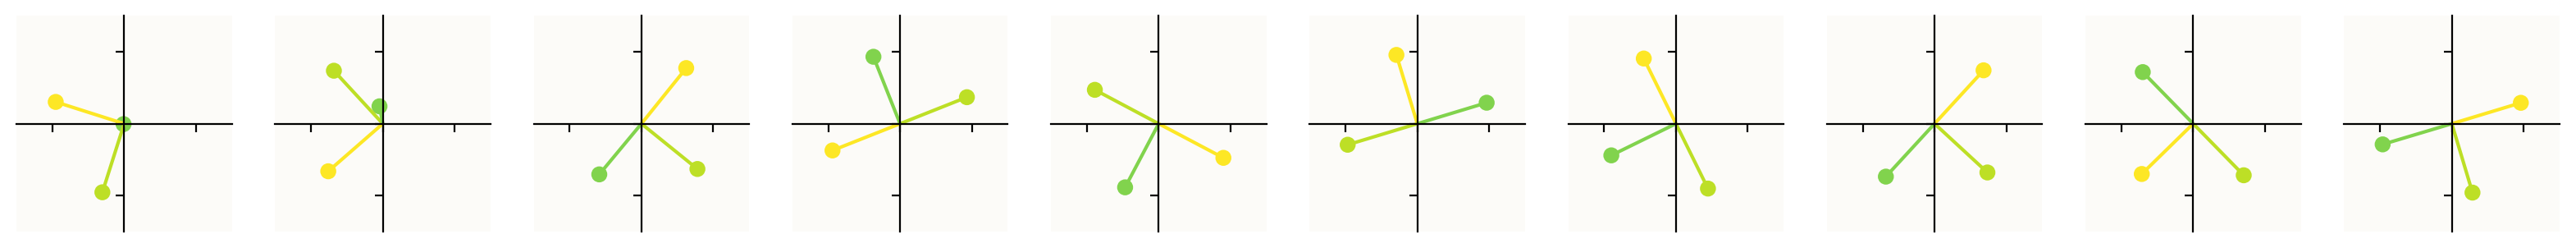

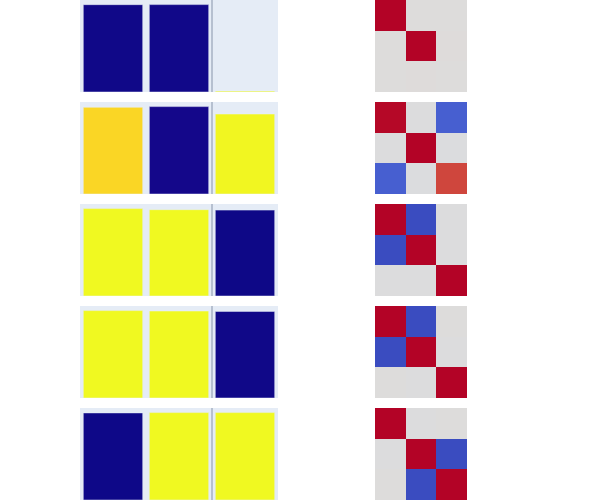

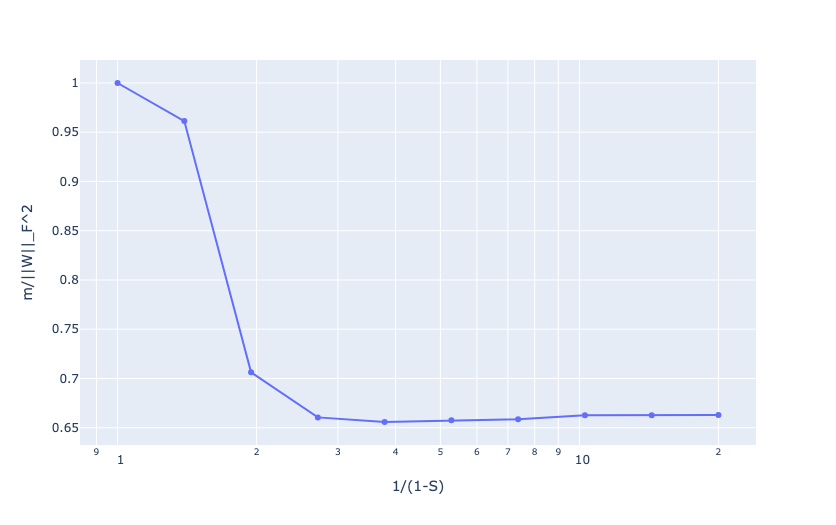